In [1]:
from audioop import cross

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import numpy.lib.recfunctions as rf

In [2]:
hsi_fm = pd.read_csv('hsi_fm.csv', index_col = 0, parse_dates = True)
hhi_fm = pd.read_csv('hhi_fm.csv', index_col = 0, parse_dates = True)

In [3]:
hsi_fm.head()

,LAST_PRICE,LAST_BID_VOLUME_0,SPREAD,LAST_BID_PRICE_0,LAST_ASK_VOLUME_0,LAST_ASK_PRICE_0
2021-01-01 00:00:00,20000,5,6,19997,4,20003
2021-01-01 00:01:00,20001,6,6,19998,5,20004
2021-01-01 00:02:00,19988,4,8,19984,4,19992
2021-01-01 00:03:00,19983,3,6,19980,5,19986
2021-01-01 00:04:00,19984,3,6,19981,5,19987


In [4]:
hsi_array = hsi_fm.drop(columns = 'SPREAD').reset_index().rename(columns={'index': 'TIMESTAMP'}).to_records(index=False)

# General Functions

In [95]:
def lagArray(data, lag=1):
    """
    Lag a numpy array by a specified number of steps.
    
    Args:
        data (numpy.ndarray): The input array.
        lag (int): The lag step (default is 1).
    
    Returns:
        numpy.ndarray: The lagged array.
    """
    # Convert to float to handle NaN values
    data = data.astype(float)
    
    lagged_data = np.empty_like(data)
    lagged_data[:lag] = np.nan  # Fill the beginning of the array with NaNs
    lagged_data[lag:] = data[:-lag]
    
    # Replace NaN with 0
    lagged_data = np.nan_to_num(lagged_data, nan=0.0)

    return lagged_data

def mapSignaltoPosition(signal: np.array, asset: np.array, cash_delta_lim: int) -> np.array:
    """
    Transforms a continuous signal into the desired position in the asset.
    
    Parameters:
        - signal (numpy.ndarray): The lagged input signal.
        - asset (numpy.ndarray): The input asset.
        - cash_delta_lim (int): The cash delta limit.
    
    Returns:
        - np.array: The transformed asset array with the desired position.
    """
    
    # adds the signal to the existing array
    asset = rf.append_fields(asset, 'SIGNALS', signal, usemask=False)
    
    # calculate the desired cash delta position at each time
    asset = rf.append_fields(asset, 'CASH_DELTA_TARGET', asset['SIGNALS'] * cash_delta_lim, usemask=False)
    
    # calculate the number of stocks required to satisfy targeted cash delta, rounding towards zero
    asset = rf.append_fields(asset, 'UNITS', np.where(asset['CASH_DELTA_TARGET'] >= 0, np.floor(asset['CASH_DELTA_TARGET'] / asset['LAST_PRICE']), np.ceil(asset['CASH_DELTA_TARGET'] / asset['LAST_PRICE'])).astype(int), usemask=False)
    
    # calculating the actual cash delta position
    asset = rf.append_fields(asset, 'CASH_DELTA_ACTUAL', asset['UNITS'] * asset['LAST_PRICE'], usemask=False)
    
    # calculating the difference in units, or the trade that needs to be done
    asset = rf.append_fields(asset, 'UNITS_DIFF', np.insert(np.diff(asset['UNITS']), 0, 0), usemask=False)
    
    return asset

def tradeCD(asset: np.ndarray) -> np.ndarray:
    """
    Generates trades required to meet cash delta target and adds the POSITION, TRADED, ACTION, and PRICE columns to the input asset array.
    
    Parameters:
        asset (np.ndarray): The input asset with the signals, target cash delta, and last available bid/ask prices and volume.
    
    Returns:
        np.ndarray: The updated asset array with the POSITION, TRADED, ACTION, and PRICE columns.
    """
    # Initialize the POSITION array with the first entry as 0
    position = np.zeros(len(asset), dtype=int)
    
    # Initialize the TRADED array
    traded = np.zeros(len(asset), dtype=int)
    
    # Initialize the ACTION and PRICE arrays
    action = np.empty(len(asset), dtype='<U4')  # 'BUY', 'SELL', or 'None'
    price = np.empty(len(asset), dtype=float)  # Prices or NaN for 'None'
    
    for i in range(1, len(asset)):
        units = asset[i]['UNITS']
        last_ask_volume = asset[i]['LAST_ASK_VOLUME_0']
        last_bid_volume = asset[i]['LAST_BID_VOLUME_0']
        
        if units > position[i-1]:
            traded[i] = min(units - position[i-1], last_ask_volume)
            action[i] = 'BUY'
            price[i] = asset[i]['LAST_ASK_PRICE_0']
        elif units < position[i-1]:
            traded[i] = -min(position[i-1] - units, last_bid_volume)
            action[i] = 'SELL'
            price[i] = asset[i]['LAST_BID_PRICE_0']
        else:
            traded[i] = 0
            action[i] = 'None'
            price[i] = np.nan
        
        # Update the POSITION for the next iteration
        position[i] = position[i-1] + traded[i]
    
    # Create the updated structured array with new columns
    updated_dtype = asset.dtype.descr + [('POSITION', 'i4'), ('TRADED', 'i4'), ('ACTION', 'U4'), ('PRICE', 'f4')]
    updated_asset = np.zeros(len(asset), dtype=updated_dtype)
    
    # Copy the original data
    for name in asset.dtype.names:
        updated_asset[name] = asset[name]
    
    # Add the new columns
    updated_asset['POSITION'] = position
    updated_asset['TRADED'] = traded
    updated_asset['ACTION'] = action
    updated_asset['PRICE'] = price
    
    return updated_asset

def povertyBacktester(lagged_signal: np.array, asset: np.array) -> np.array:
    """
    Quick backtesting for proof-of-concept signals.
    
    Parameters:
        - lagged_signal (numpy.ndarray): The lagged input signal.
        - asset (numpy.ndarray): The input asset.
    
    Returns:
        - np.array: Series of returns
    """
    
    log_rets = np.diff(np.log(asset['LAST_PRICE']))
    log_rets = np.insert(log_rets, 0,0)
    
    returns = np.cumsum(log_rets * lagged_signal)
    
    return returns

def povertyAnalytics(returns: np.array, asset: np.array, lagged_signal: np.array) -> np.array:
    """
    Quick portfolio analytics. Make sure to change number of minutes in a year etc. 
    
    Parameters:
        - returns (np.array): Series of returns.
        - assets (np.array): Input assets.
        - lagged_signal (np.array): Lagged input signal.
    
    Returns:
        - Summary statistics of portfolio
    """
    
    sharpe = (np.mean(returns) * 60 * 18 * 256) / (np.std(returns) * np.sqrt(60 * 18 * 256))
    sharpe = (np.mean(returns)) / (np.std(returns))
    
    turnover = np.sum(np.abs(np.diff(lagged_signal)))
    
    return sharpe, turnover

def toTrades(asset: np.ndarray) -> pd.DataFrame:
    """
    Filters the input numpy array for rows where 'TRADED' is not equal to 0,
    and extracts the 'TIMESTAMP', 'PRICE', 'TRADED', and 'ACTION' columns,
    converting the result to a pandas DataFrame.
    
    Parameters:
        asset (np.ndarray): The input asset array with the required columns.
    
    Returns:
        pd.DataFrame: DataFrame containing the filtered rows and specified columns.
    """
    # Filter the array for rows where 'TRADED' is not equal to 0
    filtered_asset = asset[asset['TRADED'] != 0]
    
    # Extract the specified columns
    extracted_columns = filtered_asset[['TIMESTAMP', 'PRICE', 'TRADED', 'ACTION']]
    
    # Convert the extracted data to a pandas DataFrame
    df = pd.DataFrame(extracted_columns)
    
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP']).dt.tz_localize('Asia/Hong_Kong')
    
    return df

# Moving Averages and Crossovers

## Above/Below Single Moving Average

In [30]:
def aboveMovingAverage(prices: np.ndarray, period: int) -> np.ndarray:
    """
    Signal for whether asset is above its moving average. 
    
    Parameters:
        - prices (numpy.ndarray): A numpy array consisting of price data for one asset
        - period (int): Defined lookback period for the moving average
    
    Returns:
        - numpy.ndarray: An array consisting of the signals for the asset
    """
    # Calculate the rolling moving average
    rolling_avg = np.convolve(prices, np.ones(period)/period, mode='valid')
    
    # Pad the beginning of rolling_avg to match the length of data
    rolling_avg = np.concatenate((np.full(period-1, np.nan), rolling_avg))
    
    # Generate the output array
    result = np.where(prices > rolling_avg, 1, -0)
    
    return rolling_avg, result

In [31]:
ma_example = aboveMovingAverage(hsi_array['LAST_PRICE'], 20)
ma_example

(array([     nan,      nan,      nan, ..., 13334.7 , 13337.25, 13339.95],
       shape=(1051200,)),
 array([0, 0, 0, ..., 1, 1, 1], shape=(1051200,)))

In [9]:
mapSignaltoPosition(lagArray(ma_example[1]), hsi_array, 1e6)

array([('2021-01-01T00:00:00.000000000', 20000, 5, 19997, 4, 20003, 0.,       0.,  0,      0, 0),
       ('2021-01-01T00:01:00.000000000', 20001, 6, 19998, 5, 20004, 0.,       0.,  0,      0, 0),
       ('2021-01-01T00:02:00.000000000', 19988, 4, 19984, 4, 19992, 0.,       0.,  0,      0, 0),
       ...,
       ('2022-12-31T23:57:00.000000000', 13351, 6, 13349, 6, 13353, 1., 1000000., 74, 987974, 0),
       ('2022-12-31T23:58:00.000000000', 13367, 4, 13365, 2, 13369, 1., 1000000., 74, 989158, 0),
       ('2022-12-31T23:59:00.000000000', 13364, 5, 13361, 3, 13367, 1., 1000000., 74, 988936, 0)],
      shape=(1051200,), dtype=[('TIMESTAMP', '<M8[ns]'), ('LAST_PRICE', '<i8'), ('LAST_BID_VOLUME_0', '<i8'), ('LAST_BID_PRICE_0', '<i8'), ('LAST_ASK_VOLUME_0', '<i8'), ('LAST_ASK_PRICE_0', '<i8'), ('SIGNALS', '<f8'), ('CASH_DELTA_TARGET', '<f8'), ('UNITS', '<i8'), ('CASH_DELTA_ACTUAL', '<i8'), ('UNITS_DIFF', '<i8')])

In [63]:
def processAboveBelow(hsi_array, period_list):
    results = []
    
    for x in period_list:
        # Pass through aboveMovingAverage and get the second element
        _, signal = aboveMovingAverage(hsi_array['LAST_PRICE'], x)
        
        # Pass the signal through lagArray
        lagged_signal = lagArray(signal)
        
        # Pass the lagged signal through povertyBacktester
        backtest_result = povertyBacktester(lagged_signal, hsi_array)
        
        # Pass the backtest result through povertyAnalytics
        analytics_result = povertyAnalytics(backtest_result, hsi_array, lagged_signal)
        
        # Append the results to the list
        results.append((x, analytics_result[0], analytics_result[1]))
    
    # Create a DataFrame with the results
    df_results = pd.DataFrame(results, columns=['Period', 'Return/Risk', 'Turnover'])
    df_results.set_index('Period', inplace=True)
    
    return df_results

period_list = [20, 50, 100, 200, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000]

ma_overunder_results = processAboveBelow(hsi_array, period_list)
ma_overunder_results

,Return/Risk,Turnover
Period,,
20,-0.481822,132403.0
50,-0.651972,82873.0
100,-0.781221,58165.0
200,-0.316471,41431.0
500,-0.452949,25317.0
1000,-0.087341,17939.0
2000,0.379477,12178.0
4000,-0.442302,8214.0
8000,-1.850258,5800.0


In [ ]:
# we can see that the best results appear to be with the 1000, 2000, 4000 periods
# we will flag these for further research with the official backtester

# 1000
_, signal1000 = aboveMovingAverage(hsi_array['LAST_PRICE'], 1000)
signal1000 = lagArray(signal1000)
array1000 = mapSignaltoPosition(signal1000, hsi_array, 1e6)
array1000 = tradeCD(array1000)

# 2000
_, signal2000 = aboveMovingAverage(hsi_array['LAST_PRICE'], 2000)
signal2000 = lagArray(signal2000)
array2000 = mapSignaltoPosition(signal2000, hsi_array, 1e6)
array2000 = tradeCD(array2000)

# 4000
_, signal4000 = aboveMovingAverage(hsi_array['LAST_PRICE'], 4000)
signal4000 = lagArray(signal4000)
array4000 = mapSignaltoPosition(signal4000, hsi_array, 1e6)
array4000 = tradeCD(array4000)

## Moving Average Crossover

In [65]:
def crossoverMovingAverage(prices: np.ndarray, period1: int, period2: int) -> np.ndarray:
    """
    Signal for whether the shorter-period moving average is above the longer-period moving average.
    
    Parameters:
        - prices (numpy.ndarray): A numpy array consisting of price data for one asset.
        - period1 (int): The first lookback period for the moving average (shorter period).
        - period2 (int): The second lookback period for the moving average (longer period).
    
    Returns:
        - tuple: Tuple containing the two moving averages and the signal array.
    """
    # Calculate the moving averages for both periods
    rolling_avg1 = np.convolve(prices, np.ones(period1)/period1, mode='valid')
    rolling_avg2 = np.convolve(prices, np.ones(period2)/period2, mode='valid')
    
    # Pad the beginning of the moving averages to match the length of data
    rolling_avg1 = np.concatenate((np.full(period1-1, np.nan), rolling_avg1))
    rolling_avg2 = np.concatenate((np.full(period2-1, np.nan), rolling_avg2))
    
    # Generate the signal array
    signal = np.where(np.isnan(rolling_avg1) | np.isnan(rolling_avg2), 0, np.where(rolling_avg1 > rolling_avg2, 1, -1))
    
    return rolling_avg1, rolling_avg2, signal

# Example
crossoverMovingAverage(hsi_array['LAST_PRICE'], 20, 50)[2][:100]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,
       -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1])

In [66]:
def processCrossover(hsi_array, period_list):
    results_value1 = []
    results_value2 = []
    
    for period1 in period_list:
        row_value1 = []
        row_value2 = []
        for period2 in period_list:
            if period1 < period2:
                # Pass through compareMovingAverages and get the signal
                _, _, signal = crossoverMovingAverage(hsi_array['LAST_PRICE'], period1, period2)
                
                # Pass the signal through lagArray
                lagged_signal = lagArray(signal)
                
                # Pass the lagged signal through povertyBacktester
                backtest_result = povertyBacktester(lagged_signal, hsi_array)
                
                # Pass the backtest result through povertyAnalytics
                analytics_result = povertyAnalytics(backtest_result, hsi_array, lagged_signal)
                
                # Store the results
                row_value1.append(analytics_result[0])
                row_value2.append(analytics_result[1])
            else:
                # Fill with NaN for unused combinations
                row_value1.append(np.nan)
                row_value2.append(np.nan)
        results_value1.append(row_value1)
        results_value2.append(row_value2)
    
    # Create DataFrames for the results
    df_value1 = pd.DataFrame(results_value1, index=period_list, columns=period_list)
    df_value2 = pd.DataFrame(results_value2, index=period_list, columns=period_list)
    
    return df_value1, df_value2

period_list = [20, 50, 100, 200, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000]

df_value1, df_value2 = processCrossover(hsi_array, period_list)
print("First Value Matrix:\n", df_value1)
print("\nSecond Value Matrix:\n", df_value2)

First Value Matrix:
        20        50        100       200       500       1000      2000   \
20       NaN  0.761952  0.223600  0.973305  1.443280  1.060705  1.849917   
50       NaN       NaN  0.001365  1.763344  1.284289 -0.535739  1.189701   
100      NaN       NaN       NaN  2.095434  1.577983  1.133938  0.836306   
200      NaN       NaN       NaN       NaN  0.809690  1.164004  0.638683   
500      NaN       NaN       NaN       NaN       NaN  0.817151  0.467554   
1000     NaN       NaN       NaN       NaN       NaN       NaN -0.658970   
2000     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4000     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
8000     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
16000    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
32000    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
64000    NaN       NaN       NaN       NaN       NaN       NaN     

In [85]:
df_value1 / df_value2

,20,50,100,200,500,1000,2000,4000,8000,16000,32000,64000
20,NaN,0.000016,7.678324e-06,0.000050,0.000124,0.000131,0.000338,0.000301,0.000039,0.000081,0.000950,0.001108
50,NaN,NaN,5.837295e-08,0.000133,0.000169,-0.000102,0.000334,0.000513,-0.000061,0.000205,0.001524,0.002121
100,NaN,NaN,NaN,0.000183,0.000278,0.000293,0.000336,0.000372,-0.000530,0.000198,0.002256,0.002512
200,NaN,NaN,NaN,NaN,0.000175,0.000410,0.000348,0.000459,-0.001418,0.001448,0.003319,0.002815
500,NaN,NaN,NaN,NaN,NaN,0.000362,0.000361,-0.000620,-0.001014,0.001087,0.003844,0.005345
1000,NaN,NaN,NaN,NaN,NaN,NaN,-0.000584,-0.002190,-0.005612,-0.002063,0.005081,0.002269
2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001927,-0.004002,-0.007363,0.009598,0.001254
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004709,-0.009142,0.005875,0.002497
8000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002400,0.012085,0.029241
16000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028287,0.011173


## ensTrend

In [72]:
def ema(prices, span):
    """
    Calculate the Exponential Moving Average (EMA).
    
    Parameters:
        prices (np.ndarray): Array of price data.
        span (int): Span for the EMA.
    
    Returns:
        np.ndarray: Array of EMA values.
    """
    alpha = 2 / (span + 1)
    ema = np.zeros_like(prices)
    ema[0] = prices[0]
    for i in range(1, len(prices)):
        ema[i] = alpha * prices[i] + (1 - alpha) * ema[i - 1]
    return ema

def ensTrend(prices: np.ndarray) -> np.ndarray:
    """
    Takes a series of prices, processes trend following signals based on exponentially-weighted moving average crossovers, and outputs position signals.
    
    Parameters:
        prices (np.ndarray): Array of back-adjusted price data for different assets.
        
    Returns:
        np.ndarray: Trend following signals scaled from -20 to 20.
    """
    
    # Calculate EMAs
    ema2 = np.apply_along_axis(ema, 0, prices, 2 * 24 * 60)
    ema4 = np.apply_along_axis(ema, 0, prices, 4 * 24 * 60)
    ema8 = np.apply_along_axis(ema, 0, prices, 8 * 24 * 60)
    ema16 = np.apply_along_axis(ema, 0, prices, 16 * 24 * 60)
    ema32 = np.apply_along_axis(ema, 0, prices, 32 * 24 * 60)
    
    # Calculate moving average differences
    emac2 = (ema2 - ema8) * 5.95 / prices
    emac4 = (ema4 - ema16) * 4.10 / prices
    emac8 = (ema8 - ema32) * 2.79 / prices
    
    # Create raw forecasts
    raw_forecast = 25 * (emac2 + emac4 + emac8) / 3
    
    # Cap the forecasts
    capped_forecast = np.clip(raw_forecast, -20, 20)
    capped_forecast[0] = 0  # Set the first value to 0
    
    return capped_forecast

# Example 
ensTrend(hsi_array['LAST_PRICE'])

array([0.        , 0.        , 0.        , ..., 8.06434599, 8.05469315,
       8.0565013 ], shape=(1051200,))

# Breakouts

## Individual

In [10]:
def breakoutIndividual(prices: np.ndarray, period: int) -> np.ndarray:
    """
    Generates signals for the Breakout strategy for a specific period
    
    Parameters:
        - prices (numpy.ndarray): A numpy array consisting of price data for one asset
        - period (int): Defined lookback period for the price range for the breakout signal
    
    Returns:
        - numpy.ndarray: An array consisting of the signals for the asset
    """
    
    # Convert the numpy array to a pandas Series
    prices_series = pd.Series(prices)
    
    # Calculate the rolling mean, max and min for the series
    rolling_mean = prices_series.rolling(period, min_periods=1).mean()
    rolling_max = prices_series.rolling(period, min_periods=1).max()
    rolling_min = prices_series.rolling(period, min_periods=1).min()
        
    # Calculate the raw forecast
    raw_forecast = 2 * (prices_series - rolling_mean) / (rolling_max - rolling_min)
    
    # Smooth the forecast
    smoothed_forecast = raw_forecast.ewm(span=period / 4, adjust=False).mean()
    
    # Convert the smoothed forecast to a numpy array
    result = smoothed_forecast.to_numpy()
    
    return result

# Example
breakoutIndividual(hsi_array['LAST_PRICE'], period=1000)

In [87]:
def prodBreakoutIndiv(asset: np.ndarray, period: int, cdl: int = 1e6) -> np.ndarray:
    """
    Full pipeline from signals to trades. 
    
    Parameters:
        - asset (numpy.ndarray): A numpy array consisting of price data for one asset
        - period (int): Defined lookback period for the price range for the breakout signal
        - cdl (int): Cash delta limit
    
    Returns:
        - numpy.ndarray: An array consisting of the signals for the asset
    """
    
    price = asset['LAST_PRICE']
    
    signal = breakoutIndividual(price, period)
    signal = lagArray(signal)
    
    map = mapSignaltoPosition(signal, asset, cdl)
    map = tradeCD(map)
    
    return map

prodBreakoutIndiv(hsi_array, 2000)

array([('2021-01-01T00:00:00.000000000', 20000, 5, 19997, 4, 20003,  0.        ,       0.        ,   0,       0,  0,   0, 0, '',     0.),
       ('2021-01-01T00:01:00.000000000', 20001, 6, 19998, 5, 20004,  0.        ,       0.        ,   0,       0,  0,   0, 0, 'None',    nan),
       ('2021-01-01T00:02:00.000000000', 19988, 4, 19984, 4, 19992,  1.        , 1000000.        ,  50,  999400, 50,   4, 4, 'BUY', 19992.),
       ...,
       ('2022-12-31T23:57:00.000000000', 13351, 6, 13349, 6, 13353, -0.64572999, -645729.9916953 , -48, -640848,  0, -48, 0, 'None',    nan),
       ('2022-12-31T23:58:00.000000000', 13367, 4, 13365, 2, 13369, -0.64417757, -644177.57051029, -48, -641616,  0, -48, 0, 'None',    nan),
       ('2022-12-31T23:59:00.000000000', 13364, 5, 13361, 3, 13367, -0.64233312, -642333.11789804, -48, -641472,  0, -48, 0, 'None',    nan)],
      shape=(1051200,), dtype=[('TIMESTAMP', '<M8[ns]'), ('LAST_PRICE', '<i8'), ('LAST_BID_VOLUME_0', '<i8'), ('LAST_BID_PRICE_0', '<i8'), (

## Ensemble

In [76]:
def breakoutEnsemble(prices: pd.DataFrame, periods: list) -> pd.DataFrame:
    """
    Generates signals for the Breakout strategy for multiple periods.
    
    Parameters:
        prices (pd.DataFrame): A DataFrame consisting of x observations of different assets.
        periods (list): A list of periods for the moving averages.
    
    Returns:
        pd.DataFrame: A DataFrame consisting of the signals for each of the assets.
    """
    
    # Initialize an array to store the sum of forecasts
    average_forecast = np.zeros_like(prices, dtype=float)
    
    # Apply breakoutIndividual to each period and add the results to average_forecast
    for period in periods:
        forecast = np.apply_along_axis(breakoutIndividual, 0, prices, period)
        average_forecast += forecast
    
    # Divide by the number of periods to get the average
    average_forecast /= len(periods)
    
    # Convert the numpy array back to a DataFrame
    
    return average_forecast

# Example
breakoutEnsemble(hsi_array['LAST_PRICE'], [1000, 2000, 4000])

array([        nan,  1.        ,  0.98938227, ..., -0.41191075,
       -0.40951638, -0.4072219 ], shape=(1051200,))

In [88]:
def prodBreakoutEnsemble(asset: np.ndarray, periods: list, cdl: int = 1e6) -> np.ndarray:
    """
    Full pipeline from signals to trades. 
    
    Parameters:
        - asset (numpy.ndarray): A numpy array consisting of price data for one asset
        - period (list): Defined lookback period for the price range for the breakout signal
        - cdl (int): Cash delta limit
    
    Returns:
        - numpy.ndarray: An array consisting of the signals for the asset
    """
    
    price = asset['LAST_PRICE']
    
    signal = breakoutEnsemble(price, periods)
    signal = lagArray(signal)
    
    map = mapSignaltoPosition(signal, asset, cdl)
    map = tradeCD(map)
    
    return map

# Example
prodBreakoutEnsemble(hsi_array, [1000, 2000, 4000])

array([('2021-01-01T00:00:00.000000000', 20000, 5, 19997, 4, 20003,  0.        ,       0.        ,   0,       0,  0,   0, 0, '',     0.),
       ('2021-01-01T00:01:00.000000000', 20001, 6, 19998, 5, 20004,  0.        ,       0.        ,   0,       0,  0,   0, 0, 'None',    nan),
       ('2021-01-01T00:02:00.000000000', 19988, 4, 19984, 4, 19992,  1.        , 1000000.        ,  50,  999400, 50,   4, 4, 'BUY', 19992.),
       ...,
       ('2022-12-31T23:57:00.000000000', 13351, 6, 13349, 6, 13353, -0.41386404, -413864.04191212, -30, -400530,  1, -30, 1, 'BUY', 13353.),
       ('2022-12-31T23:58:00.000000000', 13367, 4, 13365, 2, 13369, -0.41191075, -411910.75330948, -30, -401010,  0, -30, 0, 'None',    nan),
       ('2022-12-31T23:59:00.000000000', 13364, 5, 13361, 3, 13367, -0.40951638, -409516.38279319, -30, -400920,  0, -30, 0, 'None',    nan)],
      shape=(1051200,), dtype=[('TIMESTAMP', '<M8[ns]'), ('LAST_PRICE', '<i8'), ('LAST_BID_VOLUME_0', '<i8'), ('LAST_BID_PRICE_0', '<i8'), ('

# Signal Processing
see mapSignaltoPosition

# Trading towards Cash Delta

In [92]:
sample_signals = breakoutIndividual(hsi_array['LAST_PRICE'], 1000)
sample_signals = lagArray(sample_signals)

sample_map = mapSignaltoPosition(sample_signals, hsi_array, 1e6)

In [93]:
sample_trades = tradeCD(sample_map)
sample_trades

array([('2021-01-01T00:00:00.000000000', 20000, 5, 19997, 4, 20003,  0.        ,       0.        ,   0,       0,  0,   0, 0, '',     0.),
       ('2021-01-01T00:01:00.000000000', 20001, 6, 19998, 5, 20004,  0.        ,       0.        ,   0,       0,  0,   0, 0, 'None',    nan),
       ('2021-01-01T00:02:00.000000000', 19988, 4, 19984, 4, 19992,  1.        , 1000000.        ,  50,  999400, 50,   4, 4, 'BUY', 19992.),
       ...,
       ('2022-12-31T23:57:00.000000000', 13351, 6, 13349, 6, 13353, -0.26636009, -266360.09131603, -19, -253669,  1, -19, 1, 'BUY', 13353.),
       ('2022-12-31T23:58:00.000000000', 13367, 4, 13365, 2, 13369, -0.2622455 , -262245.49630368, -19, -253973,  0, -19, 0, 'None',    nan),
       ('2022-12-31T23:59:00.000000000', 13364, 5, 13361, 3, 13367, -0.2572434 , -257243.39684619, -19, -253916,  0, -19, 0, 'None',    nan)],
      shape=(1051200,), dtype=[('TIMESTAMP', '<M8[ns]'), ('LAST_PRICE', '<i8'), ('LAST_BID_VOLUME_0', '<i8'), ('LAST_BID_PRICE_0', '<i8'), ('

In [94]:
trades_df = toTrades(sample_trades)
trades_df

,TIMESTAMP,PRICE,TRADED,ACTION
0,2021-01-01 00:02:00,19992.0,4,BUY
1,2021-01-01 00:03:00,19986.0,5,BUY
2,2021-01-01 00:04:00,19987.0,5,BUY
3,2021-01-01 00:05:00,19978.0,5,BUY
4,2021-01-01 00:06:00,19972.0,6,BUY
...,...,...,...,...
131789,2022-12-31 23:43:00,13333.0,1,BUY
131790,2022-12-31 23:47:00,13340.0,1,BUY
131791,2022-12-31 23:51:00,13346.0,1,BUY
131792,2022-12-31 23:54:00,13356.0,1,BUY


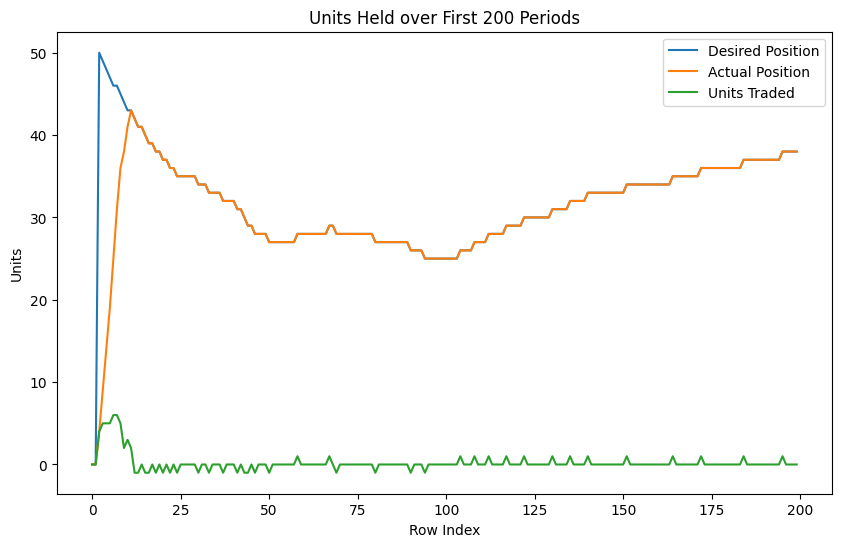

In [81]:
# Plot the first 200 periods
plt.figure(figsize=(10, 6))
plt.plot(sample_trades['UNITS'][:200], label = 'Desired Position')
plt.plot(sample_trades['POSITION'][:200], label = 'Actual Position')
plt.plot(sample_trades['TRADED'][:200], label = 'Units Traded')

plt.xlabel('Row Index')
plt.ylabel('Units')
plt.title('Units Held over First 200 Periods')
plt.legend()
plt.show()


# Step Functions / Portfolio Optimisation

In [84]:
tan_scalar = np.tanh(1)
adj_weights = np.tanh(sample_signals) / tan_scalar
adj_weights

array([ 0.        ,  0.        ,  1.        , ..., -0.34169728,
       -0.33665518, -0.33051118], shape=(1051200,))